In [416]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import visualkeras
from PIL import ImageFont
from sklearn.model_selection import KFold

In [417]:
 # (liczba próbek, liczba kanałów, liczba odczytów na kanał), a etykiety są binarne.
X = pd.read_csv(r"C:\MasterThesis\v1.0\pupil_dataset.csv")
X = X.dropna()
print(X.shape)
y = X['labels']
X = X.drop('labels', axis=1)
print(X.isnull().values.any())
X.shape

(2340, 451)
False


(2340, 450)

### Class balancing

In [418]:
sm = SMOTE(random_state=0)
X, y = sm.fit_resample(X, y)

In [419]:
X = X
y = y.values

# Reshape danych do formatu [próbki, kanały, odczyty]
# Zakładając, że masz 2 kanały i 225 odczytów na kanał
# X = X.reshape(-1, 2, 225)
print(f"x shape = {X.shape}, y shape = {y.shape}")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

x shape = (3372, 450), y shape = (3372,)
(2697, 450)


In [420]:
input_shape = (450, 1)

# Tworzenie modelu
model = Sequential()
# Dodanie warstwy LSTM
model.add(LSTM(64, input_shape=input_shape, return_sequences=True))

# Dodanie warstwy Dropout do zapobiegania przeuczeniu
model.add(Dropout(0.5))

# Dodanie drugiej warstwy LSTM
model.add(LSTM(32, return_sequences=False))

# Kolejna warstwa Dropout
model.add(Dropout(0.5))

# Dodanie warstwy Dense na końcu do przewidywania wyników
model.add(Dense(1, activation='sigmoid'))

# Kompilacja modelu
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              # metrics=['accuracy', keras.losses.mean_squared_error, tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
              metrics='accuracy')

# Wyświetlenie struktury modelu
model.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_88 (LSTM)              (None, 450, 64)           16896     
                                                                 
 dropout_84 (Dropout)        (None, 450, 64)           0         
                                                                 
 lstm_89 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_85 (Dropout)        (None, 32)                0         
                                                                 
 dense_42 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [421]:
# visualkeras.layered_view(model).show() # display using your system viewer
# visualkeras.layered_view(model, to_file='output.png') # write to disk
# visualkeras.layered_view(model, to_file='LSTM_pupilometry_model.png', min_xy=10, min_z=10, scale_xy=100, scale_z=100, one_dim_orientation='x')

In [422]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)
model_file = r"C:\Users\DAMS\PycharmProjects\MasterThesis\LSTM_pupilometry_model\model"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file,
                    monitor="val_accuracy", mode="max",
                    save_best_only=True, verbose=1, save_weights_only=True)

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val), callbacks=[early_stop, checkpoint])

Epoch 1/20
85/85 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.5050
Epoch 1: val_accuracy improved from -inf to 0.57333, saving model to C:\Users\DAMS\PycharmProjects\MasterThesis\LSTM_pupilometry_model
85/85 [==============================] - 23s 229ms/step - loss: 0.6957 - accuracy: 0.5050 - val_loss: 0.6902 - val_accuracy: 0.5733
Epoch 2/20
85/85 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.5050
Epoch 2: val_accuracy did not improve from 0.57333
85/85 [==============================] - 18s 215ms/step - loss: 0.6945 - accuracy: 0.5050 - val_loss: 0.6913 - val_accuracy: 0.5363
Epoch 3/20
85/85 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5098
Epoch 3: val_accuracy did not improve from 0.57333
85/85 [==============================] - 18s 215ms/step - loss: 0.6925 - accuracy: 0.5098 - val_loss: 0.6900 - val_accuracy: 0.5407
Epoch 4/20
85/85 [==============================] - ETA: 0s - loss: 0.6930 - accuracy

In [423]:
model.load_weights(model_file)

In [424]:
metrics = model.evaluate(X_val, y_val)
print(metrics)

22/22 [==============================] - 1s 64ms/step - loss: 0.6902 - accuracy: 0.5733
[0.6902440786361694, 0.5733333230018616]


In [425]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

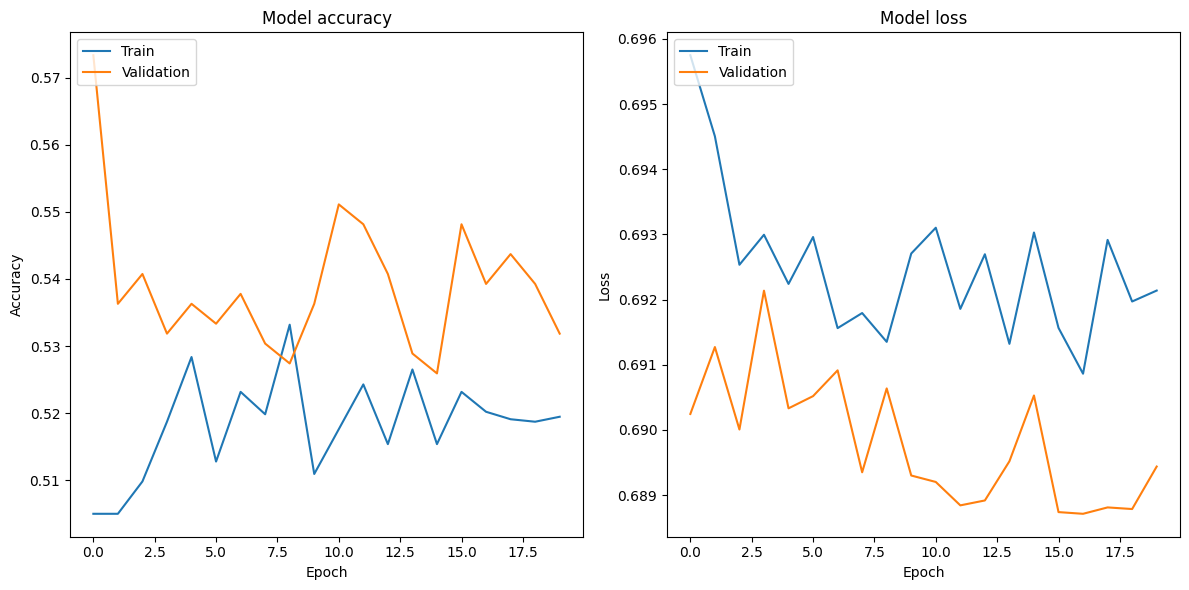

In [426]:
# Plot training & validation accuracy values
f = plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()